/var/folders/d3/6ng1rzhj0bq15fcyhb_vxc340000gn/T/ipykernel_2663/3155303118.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  Y1 = yf.download("EWH", start="2022-01-01")["Close"]
[*********************100%***********************]  1 of 1 completed
/var/folders/d3/6ng1rzhj0bq15fcyhb_vxc340000gn/T/ipykernel_2663/3155303118.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  Y2 = yf.download("EWZ", start="2022-01-01")["Close"]
[*********************100%***********************]  1 of 1 completed


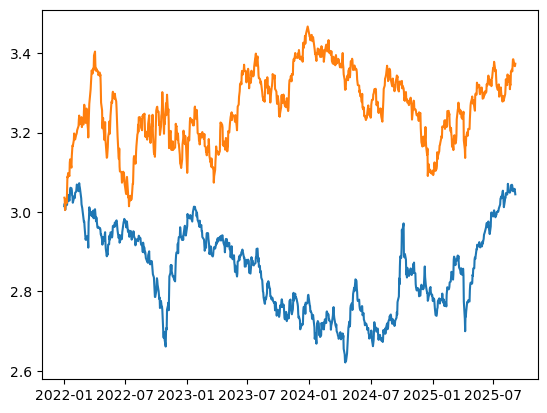

In [12]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss, coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen
import yfinance as yf
import polars as pl
import matplotlib.pyplot as plt

Y1 = yf.download("EWH", start="2022-01-01")["Close"]
Y2 = yf.download("EWZ", start="2022-01-01")["Close"]

y1 = pl.from_pandas(np.log(Y1)) 
y2 = pl.from_pandas(np.log(Y2))
spread = y1-y2
spread = spread.rename({'EWH': 'Spread'})
data = pl.concat([y1, y2, spread], how='horizontal')
data

axes = plt.subplot()
axes.plot(Y1.index, data['EWH'])
axes.plot(Y1.index, data['EWZ'])
# axes.plot(spy.index, data['Spread'])

In [13]:
def adf_test(series, **kwargs):
    # returns dict with stats
    res = adfuller(series.dropna().values, autolag=kwargs.get("autolag", "AIC"), regression=kwargs.get("regression", "c"))
    return {"stat": res[0], "pvalue": res[1], "usedlag": res[2], "nobs": res[3], "crit": res[4]}

def kpss_test(series, **kwargs):
    # returns dict with stats
    res = kpss(series.dropna().values, regression=kwargs.get("regression", "c"), nlags=kwargs.get("nlags", "auto"))
    return {"stat": res[0], "pvalue": res[1], "nlags": res[2], "crit": res[3]}

def half_life(spread):
    # estimate half-life by regressing Δs on s_{t-1}
    s = pd.Series(spread).dropna()
    s_lag = s.shift(1).dropna()
    ds = s.diff().dropna()
    # align
    s_lag = s_lag.loc[ds.index]
    if len(s_lag) < 5:
        return np.nan
    ols = sm.OLS(ds.values, sm.add_constant(s_lag.values)).fit()
    phi = ols.params[1]
    # phi is coefficient of lag in ds = a + phi * s_{t-1} + eps, relation to AR(1) slope: slope = 1 + phi
    ar1 = 1 + phi
    if ar1 <= 0 or ar1 >= 1:
        return np.inf
    hl = -np.log(2) / np.log(ar1)
    return float(hl)

def rolling_beta(y, x, window=252):
    # compute rolling OLS slope (beta)
    df = pd.concat([y, x], axis=1).dropna()
    df.columns = ["y","x"]
    betas = pd.Series(index=df.index, dtype=float)
    for i in range(window-1, len(df)):
        yw = df["y"].iloc[i-window+1:i+1]
        xw = df["x"].iloc[i-window+1:i+1]
        res = sm.OLS(yw.values, sm.add_constant(xw.values)).fit()
        betas.iloc[i] = res.params[1]
    return betas

def pair_checks(y: pd.Series, x: pd.Series, do_johansen=False, verbose=True):
    """
    Run a battery of checks for cointegration between y (dependent) and x (independent).
    Returns summary dict and diagnostics DataFrame.
    """
    # 0. Align & preprocess
    df = pd.concat({"y": y, "x": x}, axis=1).dropna()
    if df.empty:
        raise ValueError("No overlapping data between y and x after alignment.")
    yv = df["y"]
    xv = df["x"]

    out = {}
    # 1. Individual series I(1) tests
    out["adf_y_level"] = adf_test(yv, regression="c")
    out["adf_x_level"] = adf_test(xv, regression="c")
    out["kpss_y_level"] = kpss_test(yv, regression="c")
    out["kpss_x_level"] = kpss_test(xv, regression="c")

    out["adf_y_diff"] = adf_test(yv.diff().dropna(), regression="c")
    out["adf_x_diff"] = adf_test(xv.diff().dropna(), regression="c")
    out["kpss_y_diff"] = kpss_test(yv.diff().dropna(), regression="c")
    out["kpss_x_diff"] = kpss_test(xv.diff().dropna(), regression="c")

    # 2. Engle-Granger cointegration (OLS + ADF on residuals)
    X = sm.add_constant(xv.values)
    ols = sm.OLS(yv.values, X).fit()
    alpha, beta = float(ols.params[0]), float(ols.params[1])
    resid = pd.Series(ols.resid, index=df.index)
    coint_t, coint_pvalue, coint_crit = coint(yv, xv, autolag='AIC')
    out["ols_alpha"] = alpha
    out["ols_beta"] = beta
    out["engle_granger"] = {"t": float(coint_t), "pvalue": float(coint_pvalue), "crit": coint_crit}

    # residual stationarity
    out["adf_resid_n"] = adf_test(resid, regression="n")  # no constant recommended for residual ADF
    out["kpss_resid"] = kpss_test(resid, regression="c")

    # 3. Half-life of spread
    spread = yv - (alpha + beta * xv)
    out["half_life_days"] = half_life(spread)

    # 4. Rolling beta stability
    betas = rolling_beta(yv, xv, window=min(252, len(df)))
    out["rolling_beta_std"] = float(betas.dropna().std()) if betas.dropna().size>0 else np.nan
    out["rolling_beta_mean"] = float(betas.dropna().mean()) if betas.dropna().size>0 else np.nan

    # 5. optional Johansen
    if do_johansen:
        try:
            # det_order=0 (no trend), k_ar_diff = 1 as default; you may want to select more carefully
            joh = coint_johansen(df[["y","x"]].values, det_order=0, k_ar_diff=1)
            out["johansen_eig"] = joh.eig
            out["johansen_lr1"] = joh.lr1
            out["johansen_crit"] = joh.cvt
        except Exception as e:
            out["johansen_error"] = str(e)

    # 6. Diagnostics DataFrame for plotting
    diag = pd.DataFrame({
        "y": yv,
        "x": xv,
        "spread": spread,
        "resid": resid,
        "beta_roll": betas
    })

    # 7. Verdict heuristic (a starting filter)
    verdict = {}
    # Are both series non-stationary in levels? (expected for I(1) pair)
    verdict["y_level_nonstationary"] = (out["adf_y_level"]["pvalue"] > 0.05) and (out["kpss_y_level"]["pvalue"] < 0.05)
    verdict["x_level_nonstationary"] = (out["adf_x_level"]["pvalue"] > 0.05) and (out["kpss_x_level"]["pvalue"] < 0.05)
    # Engle-Granger residual stationary?
    verdict["resid_stationary"] = (out["adf_resid_n"]["pvalue"] < 0.05) and (out["kpss_resid"]["pvalue"] > 0.05)
    # Half-life reasonable?
    hl = out["half_life_days"]
    verdict["half_life_reasonable"] = (hl is not None) and (hl > 0) and (hl < 252)  # adjust upper bound as you like
    # Rolling-beta stable?
    verdict["beta_stable"] = (out["rolling_beta_std"] is not None) and (out["rolling_beta_std"] < max(0.2, abs(beta)*0.2))

    out["verdict"] = verdict
    out["diagnostics_df"] = diag
    if verbose:
        print("OLS beta =", beta, "alpha =", alpha)
        print("Engle-Granger p-value:", out["engle_granger"]["pvalue"])
        print("ADF on residuals (no constant) p-value:", out["adf_resid_n"]["pvalue"])
        print("Half-life (days):", out["half_life_days"])
        print("Rolling beta std:", out["rolling_beta_std"])
        print("Verdict summary:", verdict)

    return out
y = pd.Series(data['EWH'])
x = pd.Series(data['EWZ'])
pair_checks(y, x, do_johansen=False, verbose=True)

/var/folders/d3/6ng1rzhj0bq15fcyhb_vxc340000gn/T/ipykernel_2663/778121350.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  res = kpss(series.dropna().values, regression=kwargs.get("regression", "c"), nlags=kwargs.get("nlags", "auto"))
/var/folders/d3/6ng1rzhj0bq15fcyhb_vxc340000gn/T/ipykernel_2663/778121350.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  res = kpss(series.dropna().values, regression=kwargs.get("regression", "c"), nlags=kwargs.get("nlags", "auto"))
/var/folders/d3/6ng1rzhj0bq15fcyhb_vxc340000gn/T/ipykernel_2663/778121350.py:8: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  res = kpss(series.dropna().va

OLS beta = -0.4111700616624552 alpha = 4.195532067653745
Engle-Granger p-value: 0.3755639545032762
ADF on residuals (no constant) p-value: 0.020862481615611515
Half-life (days): 57.477818961518146
Rolling beta std: 0.2907353963274004
Verdict summary: {'y_level_nonstationary': True, 'x_level_nonstationary': False, 'resid_stationary': False, 'half_life_reasonable': True, 'beta_stable': False}


{'adf_y_level': {'stat': -1.891290876077258,
  'pvalue': 0.33616918401135437,
  'usedlag': 1,
  'nobs': 919,
  'crit': {'1%': -3.437485646962348,
   '5%': -2.8646901138095378,
   '10%': -2.568447319459459}},
 'adf_x_level': {'stat': -3.2909344144504264,
  'pvalue': 0.015288601768065398,
  'usedlag': 0,
  'nobs': 920,
  'crit': {'1%': -3.4374778690219956,
   '5%': -2.864686684217556,
   '10%': -2.5684454926748583}},
 'kpss_y_level': {'stat': 1.3201668832707985,
  'pvalue': 0.01,
  'nlags': 18,
  'crit': {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}},
 'kpss_x_level': {'stat': 1.0857670352039304,
  'pvalue': 0.01,
  'nlags': 18,
  'crit': {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}},
 'adf_y_diff': {'stat': -28.96762904985006,
  'pvalue': 0.0,
  'usedlag': 0,
  'nobs': 919,
  'crit': {'1%': -3.437485646962348,
   '5%': -2.8646901138095378,
   '10%': -2.568447319459459}},
 'adf_x_diff': {'stat': -14.156626595319672,
  'pvalue': 2.116088293161319e-26,
  'usedlag': 4,
